In [115]:
import sys
!{sys.executable} -m pip install "qiskit[all]" mqt.ddsim

# Grover Example

In [116]:
from qiskit import *
from numpy import pi
import numpy as np
from qiskit.algorithms import Grover

## Initialization

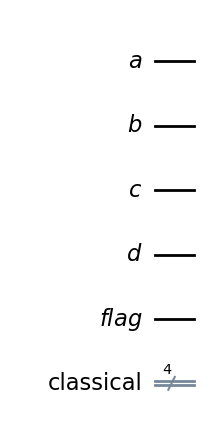

In [117]:
a = QuantumRegister(1, "a")
b = QuantumRegister(1, "b")
c = QuantumRegister(1, "c")
d = QuantumRegister(1, "d")
flag = QuantumRegister(1, "flag")
creg_c = ClassicalRegister(4, "classical")
circuit = QuantumCircuit(a, b, c, d, flag, creg_c)
circuit.draw(output="mpl")

## Superposition of all States

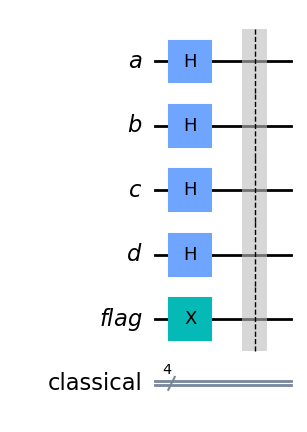

In [118]:
# put all qubits to superposition
circuit.h(a)
circuit.h(b)
circuit.h(c)
circuit.h(d)

# apply "not" gate to flag. This is important for marking the solution state
circuit.x(flag)
circuit.barrier(a, b, c, d, flag)
circuit.draw(output="mpl")

## Grover Iterations: Oracle and Diffusor / Amplitude Amplification

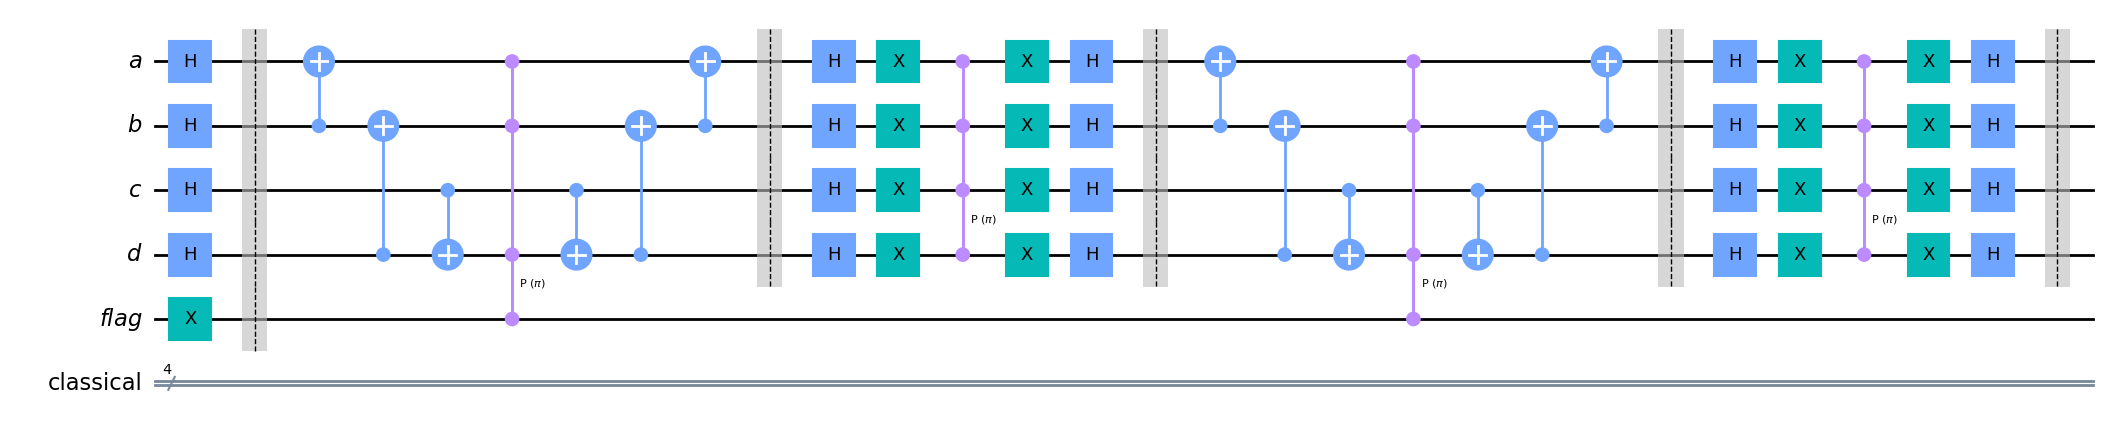

In [119]:

for i in range(2):
    # Oracle
    # 3 qubits in the picture before (d != c, b != d, a != b)
    circuit.cx(b, a)

    circuit.cx(d, b)
    circuit.cx(c, d)
    # if b c d are 1, apply phase to flag, which flips the amplitude
    # pi rotation means flip the sign (of the flag)
    circuit.mcp(np.pi, [b, a, d], flag)
    
    # operation is reversible, Uncompute. do not create entanglement
    # Oracle takes the input gives the input as an output, and only marks the solution.
    # That's why we have uncompute.
    
    circuit.cx(c, d)
    circuit.cx(d, b)
    circuit.cx(b, a)
    circuit.barrier(a, b, c, d)
    
    # Diffusor / Amplitude Amplification
    # standard structure of hadamard. always the same: hadamard - x - phase gate - x - hadamard
    circuit.h(a)
    circuit.h(b)
    circuit.h(c)
    circuit.h(d)
    circuit.x(d)
    circuit.x(a)
    circuit.x(b)
    circuit.x(c)
    circuit.mcp(np.pi, [a, b, c], d)
    circuit.x(d)
    circuit.x(c)
    circuit.x(b)
    circuit.x(a)
    circuit.h(d)
    circuit.h(c)
    circuit.h(b)
    circuit.h(a)
    circuit.barrier(a, b, c, d)
    
circuit.draw(output="mpl", fold=-1)

In [120]:
# print(circuit.qasm())

## Measurements

In [121]:
# take the qubit a and measure it to classical register 0
circuit.measure(a, creg_c[0])
circuit.measure(b, creg_c[1])
circuit.measure(c, creg_c[2])
circuit.measure(d, creg_c[3])
# circuit.draw(output="mpl", fold=-1)

## Execution on Simulator

In [122]:
from mqt import ddsim
from qiskit.visualization import plot_histogram

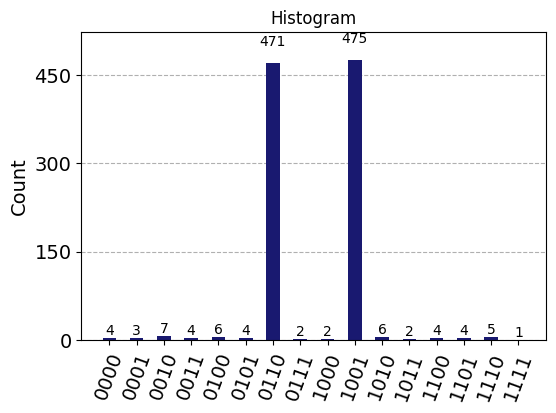

In [123]:
backend = ddsim.DDSIMProvider().get_backend("qasm_simulator")
job = execute(circuit, backend, shots=1000)
counts = job.result().get_counts(circuit)
plot_histogram(counts, color="midnightblue", title="Histogram", figsize=(6, 4))

# MaxCut with VQAs
Example is adapted from https://qiskit.org/documentation/optimization/tutorials/06_examples_max_cut_and_tsp.html

In [124]:
import matplotlib.pyplot as plt
import matplotlib.axes as axes
import numpy as np
import networkx as nx

from qiskit import Aer
from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import TwoLocal
from qiskit_optimization.applications import Maxcut, Tsp
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SPSA
from qiskit.utils import algorithm_globals, QuantumInstance
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.problems import QuadraticProgram
from qiskit.algorithms.minimum_eigen_solvers import QAOA

## Problem Definition

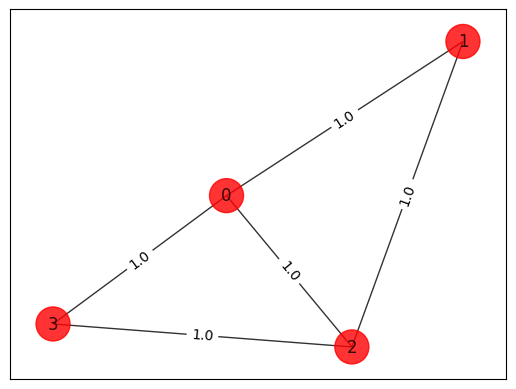

In [125]:
n = 4  # Number of nodes in graph
G = nx.Graph()
G.add_nodes_from(np.arange(0, n, 1))
elist = [(0, 1, 1.0), (0, 2, 1.0), (0, 3, 1.0), (1, 2, 1.0), (2, 3, 1.0)]
# tuple is (i,j,weight) where (i,j) is the edge
G.add_weighted_edges_from(elist)

colors = ["r" for node in G.nodes()]
pos = nx.spring_layout(G)


def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)


draw_graph(G, colors, pos)

## Mapping problem to suitable format for Quantum Computing

### Representation as Adjacency Matrix

In [126]:
# Computing the weight matrix from the random graph
w = np.zeros([n, n])
for i in range(n):
    for j in range(n):
        temp = G.get_edge_data(i, j, default=0)
        if temp != 0:
            w[i, j] = temp["weight"]
print(w)

[[0. 1. 1. 1.]
 [1. 0. 1. 0.]
 [1. 1. 0. 1.]
 [1. 0. 1. 0.]]


### Formulating as a QUBO

In [127]:
max_cut = Maxcut(w)
qp = max_cut.to_quadratic_program()
print(qp.prettyprint())

Problem name: Max-cut

Maximize
  -2*x_0*x_1 - 2*x_0*x_2 - 2*x_0*x_3 - 2*x_1*x_2 - 2*x_2*x_3 + 3*x_0 + 2*x_1
  + 3*x_2 + 2*x_3

Subject to
  No constraints

  Binary variables (4)
    x_0 x_1 x_2 x_3



### Creating a Hamiltonian from QUBO by transforming it to a Ising Formulation first

In [128]:
qubitOp, offset = qp.to_ising()
print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(qubitOp))

Offset: -2.5
Ising Hamiltonian:
0.5 * IIZZ
+ 0.5 * IZIZ
+ 0.5 * ZIIZ
+ 0.5 * IZZI
+ 0.5 * ZZII


## Use VQE algorithm to solve it

In [129]:
backend = ddsim.DDSIMProvider().get_backend("qasm_simulator")
quantum_instance = QuantumInstance(backend)

/tmp/ipykernel_672/423538010.py:2: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend)


### Select ansatz and initialize VQE solver

/tmp/ipykernel_672/2126276657.py:4: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(ry, optimizer=spsa, quantum_instance=quantum_instance)


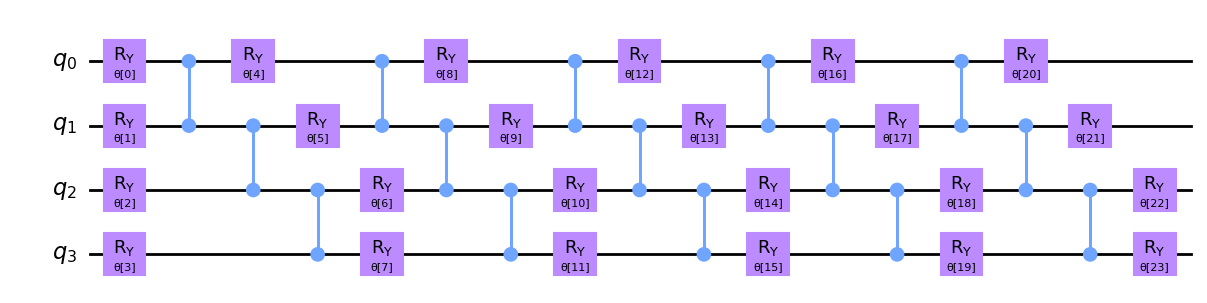

In [130]:
# construct VQE
spsa = SPSA(maxiter=300)
ry = TwoLocal(qubitOp.num_qubits, "ry", "cz", reps=5, entanglement="linear")
vqe = VQE(ry, optimizer=spsa, quantum_instance=quantum_instance)
vqe.ansatz.decompose().draw(output="mpl", fold=-1)

### Execute VQE and print Result

In [131]:
result = vqe.compute_minimum_eigenvalue(qubitOp)

x = max_cut.sample_most_likely(result.eigenstate)
print("energy:", result.eigenvalue.real)
print("time:", result.optimizer_time)
print("max-cut objective:", result.eigenvalue.real + offset)
print("solution:", x)
print("solution objective:", qp.objective.evaluate(x))

energy: -1.5
time: 6.976653337478638
max-cut objective: -4.0
solution: [0 1 0 1]
solution objective: 4.0


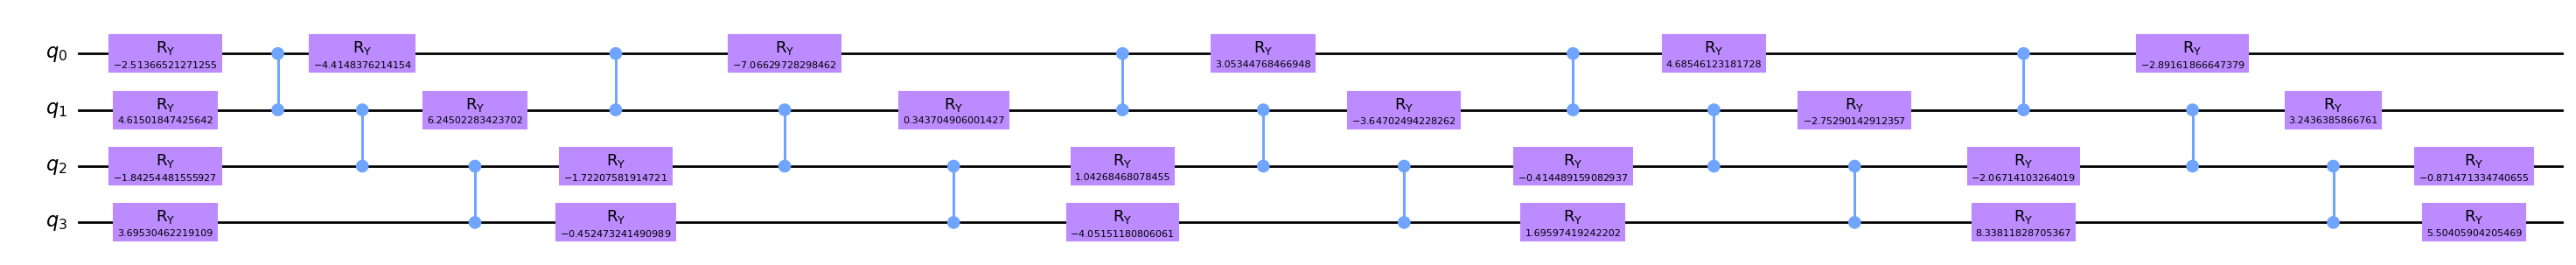

In [132]:
qc = vqe.ansatz.bind_parameters(result.optimal_point)
qc.decompose().draw(output="mpl", fold=-1)

## Visualize Result

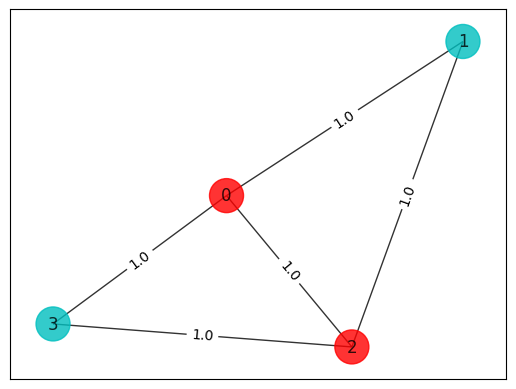

In [133]:
# plot results
colors = ["r" if x[i] == 0 else "c" for i in range(n)]
draw_graph(G, colors, pos)
